### EXPLORATION 

In [1]:
import pandas as pd 
import os 
cwd = os.getcwd()
meta_data_df = pd.read_csv(f'{cwd}/metadata.csv')
meta_data_df.head()

image_id     domain  split                 image_path
0  n02381460_1000  B (Zebra)   test   testB/n02381460_1000.jpg
1  n02381460_1001  A (Horse)  train  trainA/n02381460_1001.jpg
2  n02381460_1002  A (Horse)  train  trainA/n02381460_1002.jpg
3  n02381460_1003  A (Horse)  train  trainA/n02381460_1003.jpg
4  n02381460_1006  A (Horse)  train  trainA/n02381460_1006.jpg

In [2]:
from imageio import imread
import numpy as np
HOME_DIR = f'/home/shreyamm/Desktop/UPenn/projects/udt/'
DATA_DIR = os.path.join(HOME_DIR, 'data/horse2zebra')
img_path = f'{DATA_DIR}/testB/n02391049_100.jpg'
img = np.array(imread(img_path))
img_gs = np.mean(img, -1) # converting image to gray-scale

/tmp/ipykernel_2062310/496372502.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = np.array(imread(img_path))


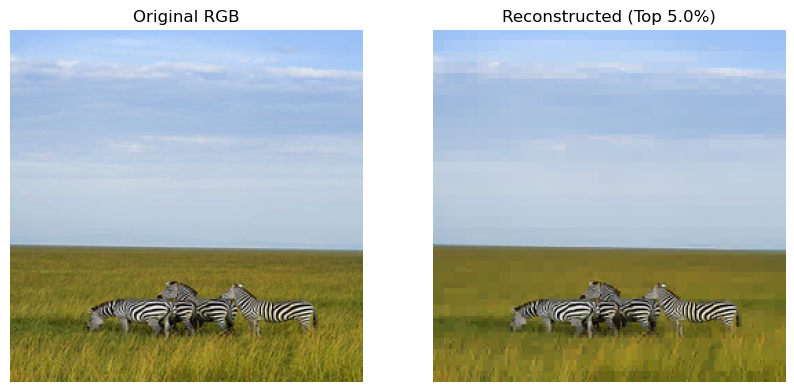

In [3]:
import os
import numpy as np
import pywt
import matplotlib.pyplot as plt
from imageio import imread

def process_channel(channel, wavelet='db1', level=8, keep=0.2):
    coeffs = pywt.wavedec2(channel, wavelet=wavelet, level=level)
    coeff_arr, coeff_slices = pywt.coeffs_to_array(coeffs)

    Csort = np.sort(np.abs(coeff_arr.reshape(-1)))
    thresh = Csort[int(np.floor((1 - keep) * len(Csort)))]
    
    ind = np.abs(coeff_arr) > thresh
    Cfilt = coeff_arr * ind 
    
    coeffs_filt = pywt.array_to_coeffs(Cfilt, coeff_slices, output_format='wavedec2')
    recon = pywt.waverec2(coeffs_filt, wavelet=wavelet)
    return recon[:channel.shape[0], :channel.shape[1]], coeffs_filt


wavelet_type = 'db1'
n_level = 3
keep_ratio = 0.05

# Apply to R, G, B separately
channel_recons = []
coeffs_filt = []
for i in range(3):
    channel = img[:, :, i]
    recon_ch, coeffs = process_channel(channel, wavelet=wavelet_type, level=n_level, keep=keep_ratio)
    channel_recons.append(recon_ch)
    coeffs_filt.append(coeffs)

# Stack back into (H, W, 3)
recon_rgb = np.stack(channel_recons, axis=-1)

# Clip to range [0, 255] and convert to uint8
recon_rgb = np.clip(recon_rgb, 0, 255).astype('uint8')

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original RGB")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(recon_rgb)
plt.title(f"Reconstructed (Top {keep_ratio*100}%)")
plt.axis('off')
plt.show()

In [4]:
import os
import glob
import random
import numpy as np
import pandas as pd
import pywt
from imageio import imread
from scipy import sparse
from tqdm import tqdm
from PIL import Image


WAVELET_TYPE = 'db1'
LEVEL = 3       
KEEP_RATIO = 0.2
IMG_SIZE = (256, 256) 

def get_sparse_wavelet_vector(img_path):
    img = Image.open(img_path).convert('RGB').resize(IMG_SIZE)
    img_arr = np.array(img)

    channel_vectors = []
    
    for i in range(3): # R, G, B
        channel = img_arr[:, :, i]
        coeffs = pywt.wavedec2(channel, wavelet=WAVELET_TYPE, level=LEVEL)
        coeff_arr, _ = pywt.coeffs_to_array(coeffs)
        
        flat_coeffs = coeff_arr.reshape(-1)
        threshold_idx = int(np.floor((1 - KEEP_RATIO) * len(flat_coeffs)))
        threshold = np.sort(np.abs(flat_coeffs))[threshold_idx]
        
        flat_coeffs[np.abs(flat_coeffs) <= threshold] = 0
        
        channel_vectors.append(sparse.csr_matrix(flat_coeffs))
    
    full_vector = sparse.hstack(channel_vectors)
    return full_vector

import os 
HOME_DIR = f'/home/shreyamm/Desktop/UPenn/projects/udt/'
DATA_DIR = os.path.join(HOME_DIR, 'data/horse2zebra')
files_A = glob.glob(f'{DATA_DIR}/trainA/*.jpg')
files_B = glob.glob(f'{DATA_DIR}/trainB/*.jpg')

dataset_list = []
for f in files_A:
    dataset_list.append({'path': f, 'domain': 'A', 'label': 0})
for f in files_B:
    dataset_list.append({'path': f, 'domain': 'B', 'label': 1})

random.shuffle(dataset_list)
print(f"Processing {len(dataset_list)} images...")

data_rows = []
meta_rows = []

for item in tqdm(dataset_list):
    vec = get_sparse_wavelet_vector(item['path'])
    data_rows.append(vec)
    meta_rows.append(item)

W = sparse.vstack(data_rows)
df_meta = pd.DataFrame(meta_rows)

print(f"Matrix W constructed. Shape: {W.shape}")
print(f"Sparsity: {1.0 - (W.nnz / (W.shape[0] * W.shape[1])):.4f}")

Processing 2401 images...


 41%|████▏     | 995/2401 [00:08<00:11, 117.55it/s]

100%|██████████| 2401/2401 [00:20<00:00, 118.25it/s]


Matrix W constructed. Shape: (2401, 196608)
Sparsity: 0.8003


In [5]:
from scipy import sparse
# Saves the Sparse Matrix efficiently
EXP_DIR = os.path.join(HOME_DIR, 'experiments/horse2zebra')
sparse.save_npz(f'{EXP_DIR}/data_matrix_W.npz', W)
# which row corresponds to which image/domain
df_meta.to_csv(f'{EXP_DIR}/metadata_W.csv', index=False)


In [6]:
from scipy import sparse
import pandas as pd
import os 
EXP_DIR = os.path.join(HOME_DIR, 'experiments/horse2zebra')
W = sparse.load_npz(f'{EXP_DIR}/data_matrix_W.npz')
df_meta = pd.read_csv(f'{EXP_DIR}/metadata_W.csv')

print(f"Loaded W: {W.shape}")
print(f"Loaded Meta: {len(df_meta)} rows")

Loaded W: (2401, 196608)
Loaded Meta: 2401 rows


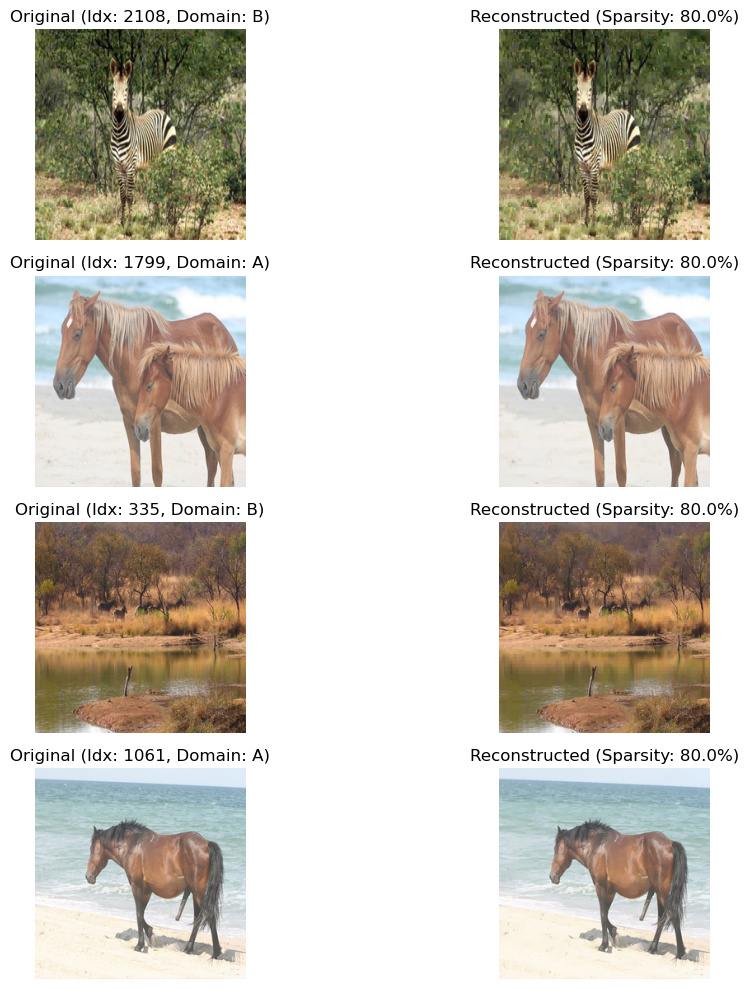

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pywt
from PIL import Image

IMG_SIZE = (256, 256)
WAVELET_TYPE = 'db1'
LEVEL = 3

dummy_img = np.zeros(IMG_SIZE)
coeffs = pywt.wavedec2(dummy_img, wavelet=WAVELET_TYPE, level=LEVEL)
arr, coeff_slices = pywt.coeffs_to_array(coeffs)
coeff_shape = arr.shape  

def reconstruct_image_from_vector(sparse_row, slices, dest_shape, wavelet_shape):
    """
    Reconstructs an RGB image from a sparse flattened wavelet vector.
    """
    dense_vec = sparse_row.toarray().flatten()
    n_coeffs_per_channel = len(dense_vec) // 3
    
    recon_channels = []
    
    for i in range(3):
        start = i * n_coeffs_per_channel
        end = start + n_coeffs_per_channel
 
        channel_coeffs_flat = dense_vec[start:end]
        channel_coeffs_reshaped = channel_coeffs_flat.reshape(wavelet_shape)
        coeffs_rebuilt = pywt.array_to_coeffs(channel_coeffs_reshaped, slices, output_format='wavedec2')
        channel_recon = pywt.waverec2(coeffs_rebuilt, wavelet=WAVELET_TYPE)

        channel_recon = channel_recon[:dest_shape[0], :dest_shape[1]]
        recon_channels.append(channel_recon)
        
    recon_rgb = np.stack(recon_channels, axis=-1)
    return np.clip(recon_rgb, 0, 255).astype('uint8')

indices_to_check = np.random.choice(len(df_meta), 4, replace=False)

plt.figure(figsize=(12, 10))

for i, idx in enumerate(indices_to_check):
    row_data = df_meta.iloc[idx]
    original_path = row_data['path']
    domain = row_data['domain']

    img_orig = Image.open(original_path).convert('RGB').resize(IMG_SIZE)

    sparse_vector = W[idx]
    img_recon = reconstruct_image_from_vector(sparse_vector, coeff_slices, IMG_SIZE, coeff_shape)

    plt.subplot(4, 2, 2*i + 1)
    plt.imshow(img_orig)
    plt.title(f"Original (Idx: {idx}, Domain: {domain})")
    plt.axis('off')
    
    plt.subplot(4, 2, 2*i + 2)
    plt.imshow(img_recon)
    
    sparsity = 1.0 - (sparse_vector.nnz / sparse_vector.shape[1])
    plt.title(f"Reconstructed (Sparsity: {sparsity:.1%})")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [15]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import numpy as np

N_COMPONENTS = 512  # Number of singular values/vectors to compute
RANDOM_STATE = 42

print(f"Starting SVD with {N_COMPONENTS} components...")
svd = TruncatedSVD(n_components=N_COMPONENTS, random_state=RANDOM_STATE)
# Z is new latent representation: shape (N_samples, N_components)
Z = svd.fit_transform(W)

print(f"SVD Complete.")
print(f"Latent shape Z: {Z.shape}")

Starting SVD with 512 components...


SVD Complete.
Latent shape Z: (2401, 512)


In [16]:
import numpy as np
import joblib 

np.save(f'{EXP_DIR}/Z_latent.npy', Z)
joblib.dump(svd, f'{EXP_DIR}/svd_model.joblib')

print("Saved Z and SVD model successfully.")

Saved Z and SVD model successfully.


In [17]:
import joblib 
import numpy as np
Z = np.load(f'{EXP_DIR}/Z_latent.npy')
svd = joblib.load(f'{EXP_DIR}/svd_model.joblib')

Total Variance Explained: 85.78%


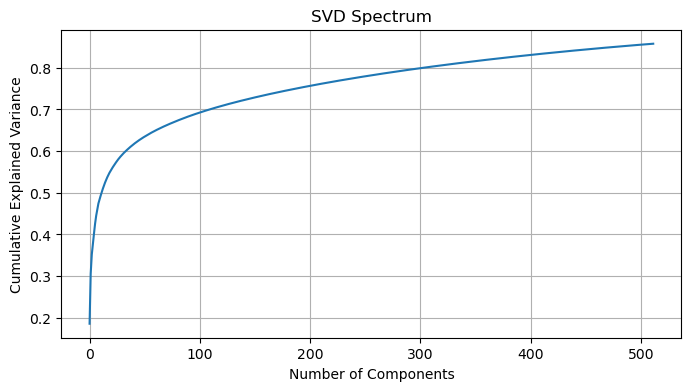

In [18]:
explained_var = svd.explained_variance_ratio_.sum()
print(f"Total Variance Explained: {explained_var:.2%}")

plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(svd.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('SVD Spectrum')
plt.grid(True)
plt.show()


C          | Train Acc  | Val Acc    | Active Feats (domain-varying) | Inactive (domain-invariant)
--------------------------------------------------------------------------------
0.001      | 0.811      | 0.644      | 436                  | 76
0.01       | 0.815      | 0.615      | 487                  | 25


0.1        | 0.814      | 0.617      | 490                  | 22
1.0        | 0.813      | 0.632      | 486                  | 26
10.0       | 0.814      | 0.630      | 485                  | 27

Selection Complete.
Content Dimensions (Invariant): 417
Style Dimensions (Domain Specific): 95


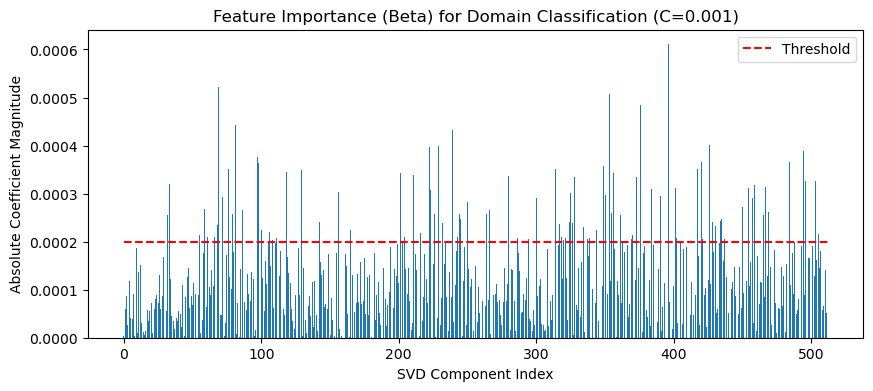

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

y = np.array([item['label'] for item in df_meta.to_dict('records')])
X_train, X_val, y_train, y_val = train_test_split(Z, y, test_size=0.2, random_state=42)

# C = inverse of regularization strength 
# Small C = Fewer active features (more sparsity)
# trying a few values to find the balance
c_values = [0.001, 0.01, 0.1, 1.0, 10.0]

best_model = None
best_acc = 0

print(f"{'C':<10} | {'Train Acc':<10} | {'Val Acc':<10} | {'Active Feats (domain-varying)':<20} | {'Inactive (domain-invariant)'}")
print("-" * 80)

for C in c_values:
    clf = LogisticRegression(penalty='l1', C=C, solver='liblinear', random_state=42)
    # using l1 penalty to ensure sparsity
    clf.fit(X_train, y_train)
    
    train_acc = clf.score(X_train, y_train)
    val_acc = clf.score(X_val, y_val)

    coefs = clf.coef_.flatten()
    n_active = np.sum(np.abs(coefs) > 1e-5)
    n_inactive = len(coefs) - n_active
    
    print(f"{C:<10} | {train_acc:.3f}      | {val_acc:.3f}      | {n_active:<20} | {n_inactive}")

    if val_acc > best_acc:
        best_acc = val_acc
        best_model = clf

beta = best_model.coef_.flatten()

threshold = 2e-4 
active_mask = np.abs(beta) > threshold   # Domain-Variant Subspace
inactive_mask = ~active_mask             # Domain Invariant Subspace

print("\nSelection Complete.")
print(f"Content Dimensions (Invariant): {np.sum(inactive_mask)}")
print(f"Style Dimensions (Domain Specific): {np.sum(active_mask)}")

plt.figure(figsize=(10, 4))
plt.bar(range(len(beta)), np.abs(beta))
plt.xlabel('SVD Component Index')
plt.ylabel('Absolute Coefficient Magnitude')
plt.title(f'Feature Importance (Beta) for Domain Classification (C={best_model.C})')
plt.hlines(threshold, 0, len(beta), colors='r', linestyles='dashed', label='Threshold')
plt.legend()
plt.show()

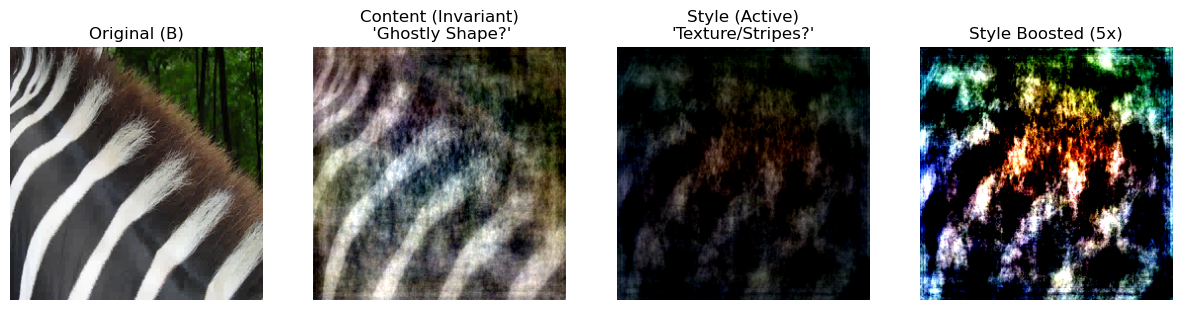

In [12]:
# --- Visualizing the Split ---
# We use the 'best_model' and the masks you generated
# active_mask (Style), inactive_mask (Content)

idx = np.random.choice(len(df_meta)) # Pick a random image
z_sample = Z[idx]
original_shape = IMG_SIZE

# 1. Split the latent vector
z_content = z_sample.copy()
z_content[active_mask] = 0  # Zero out style, keep content

z_style = z_sample.copy()
z_style[inactive_mask] = 0  # Zero out content, keep style

# 2. Invert SVD to get back to Wavelet Space
# shape: (1, n_features)
w_content = svd.inverse_transform(z_content.reshape(1, -1))
w_style = svd.inverse_transform(z_style.reshape(1, -1))

# 3. Reconstruct Images (using your helper function)
# Note: We pass the sparse vector row structure 
# (We need to convert the dense w_content back to sparse or modify helper.
#  Easier to just modify the helper logic slightly for dense input or cast to sparse)

img_content = reconstruct_image_from_vector(sparse.csr_matrix(w_content), coeff_slices, original_shape, coeff_shape)
img_style = reconstruct_image_from_vector(sparse.csr_matrix(w_style), coeff_slices, original_shape, coeff_shape)
img_original = reconstruct_image_from_vector(W[idx], coeff_slices, original_shape, coeff_shape)

# 4. Plot
plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.imshow(img_original)
plt.title(f"Original ({df_meta.iloc[idx]['domain']})")
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(img_content)
plt.title("Content (Invariant)\n 'Ghostly Shape?'")
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(img_style)
plt.title("Style (Active)\n'Texture/Stripes?'")
plt.axis('off')

plt.subplot(1, 4, 4)
# Visualizing Style Enhanced (Contrast boosted)
plt.imshow(np.clip(img_style * 5.0, 0, 255).astype('uint8')) 
plt.title("Style Boosted (5x)")
plt.axis('off')

plt.show()

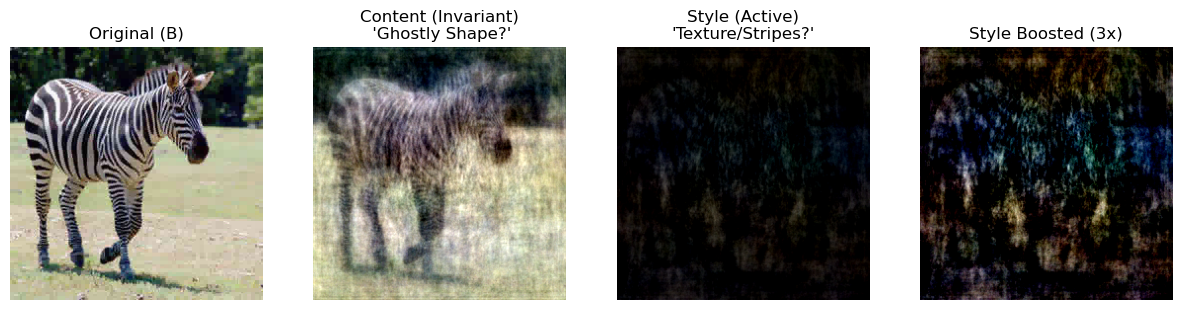

In [23]:
# --- Visualizing the Split ---
# We use the 'best_model' and the masks you generated
# active_mask (Style), inactive_mask (Content)

idx = np.random.choice(len(df_meta)) # Pick a random image
z_sample = Z[idx]
original_shape = IMG_SIZE

# 1. Split the latent vector
z_content = z_sample.copy()
z_content[active_mask] = 0  # Zero out style, keep content

z_style = z_sample.copy()
z_style[inactive_mask] = 0  # Zero out content, keep style

# 2. Invert SVD to get back to Wavelet Space
# shape: (1, n_features)
w_content = svd.inverse_transform(z_content.reshape(1, -1))
w_style = svd.inverse_transform(z_style.reshape(1, -1))

# 3. Reconstruct Images (using your helper function)
# Note: We pass the sparse vector row structure 
# (We need to convert the dense w_content back to sparse or modify helper.
#  Easier to just modify the helper logic slightly for dense input or cast to sparse)

img_content = reconstruct_image_from_vector(sparse.csr_matrix(w_content), coeff_slices, original_shape, coeff_shape)
img_style = reconstruct_image_from_vector(sparse.csr_matrix(w_style), coeff_slices, original_shape, coeff_shape)
img_original = reconstruct_image_from_vector(W[idx], coeff_slices, original_shape, coeff_shape)

# 4. Plot
plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.imshow(img_original)
plt.title(f"Original ({df_meta.iloc[idx]['domain']})")
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(img_content)
plt.title("Content (Invariant)\n 'Ghostly Shape?'")
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(img_style)
plt.title("Style (Active)\n'Texture/Stripes?'")
plt.axis('off')

plt.subplot(1, 4, 4)
# Visualizing Style Enhanced (Contrast boosted)
plt.imshow(np.clip(img_style * 3.0, 0, 255).astype('uint8')) 
plt.title("Style Boosted (3x)")
plt.axis('off')

plt.show()

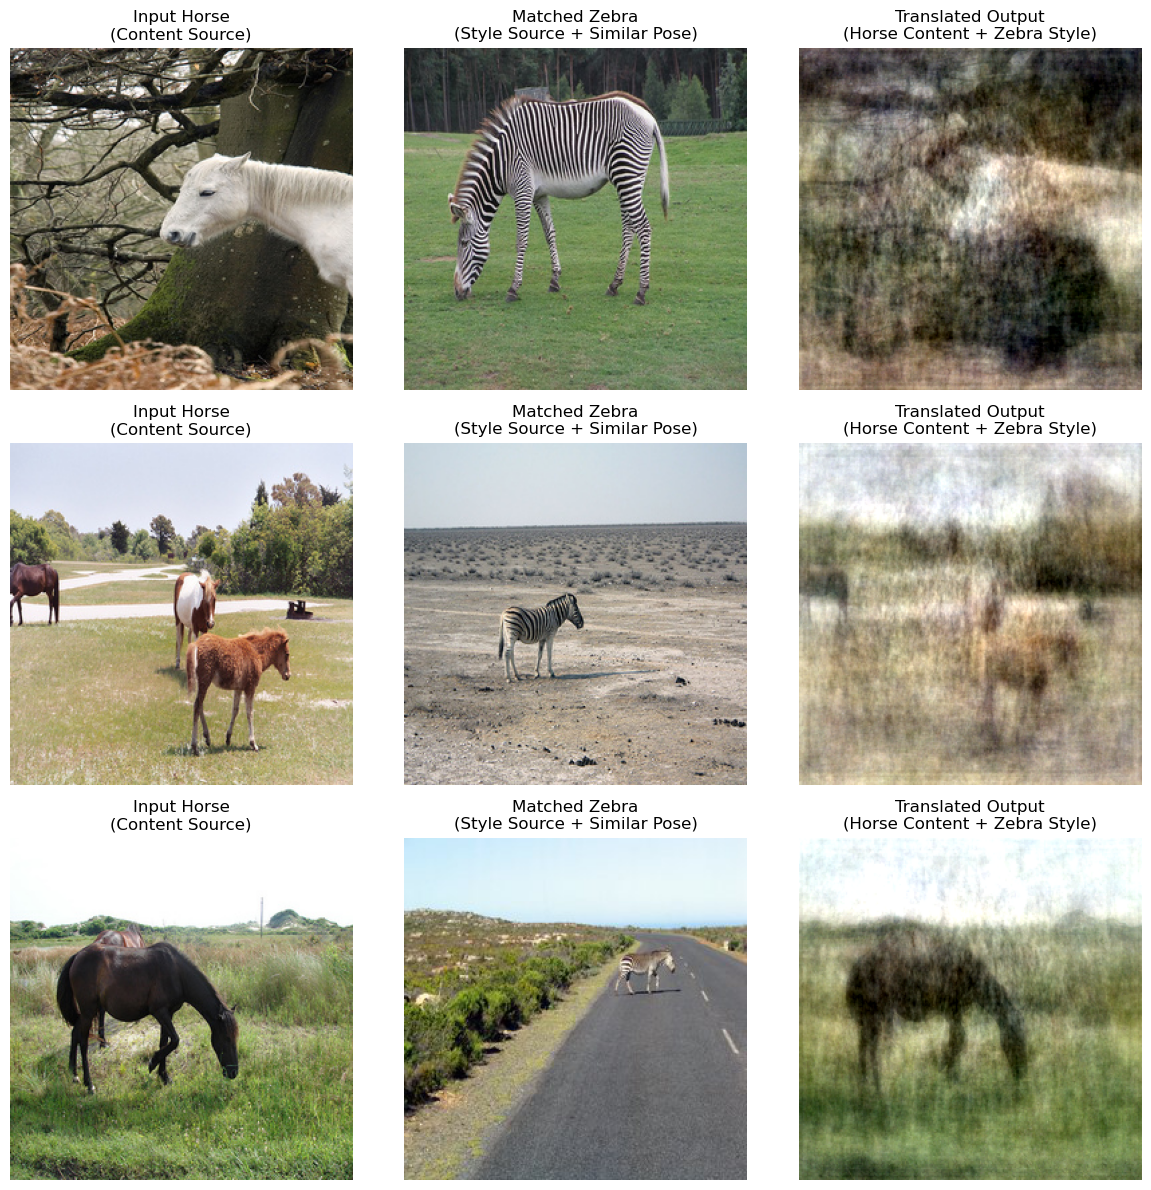

In [13]:
from sklearn.neighbors import NearestNeighbors

# --- 1. Setup the Databases ---
# We need to separate the latent vectors Z by domain
indices_A = [i for i, x in enumerate(df_meta['domain']) if x == 'A']
indices_B = [i for i, x in enumerate(df_meta['domain']) if x == 'B']

Z_A = Z[indices_A]
Z_B = Z[indices_B]

# Helper to map back from subset index to global index (for plotting original images)
def get_global_idx(subset_idx, domain):
    if domain == 'A': return indices_A[subset_idx]
    else: return indices_B[subset_idx]

# --- 2. Build the Matcher ---
# We match based ONLY on the Inactive (Content) dimensions.
# We want to find a Zebra (B) that has the same pose as the query Horse (A).

# Filter Z_B to keep only content dimensions
Z_B_content = Z_B[:, inactive_mask]

# Fit Nearest Neighbor model on Domain B's content
nbrs_B = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(Z_B_content)

# --- 3. The Translation Function ---
def translate_A_to_B(idx_A_local):
    # a. Get the Horse Latent
    z_horse = Z_A[idx_A_local]
    
    # b. Extract Horse Content
    content_query = z_horse[inactive_mask].reshape(1, -1)
    
    # c. Find the closest Zebra (Match on Content)
    distances, indices = nbrs_B.kneighbors(content_query)
    idx_B_match = indices[0][0]
    z_zebra_match = Z_B[idx_B_match]
    
    # d. Frankenstein Synthesis
    # Start with zeros
    z_hybrid = np.zeros_like(z_horse)
    
    # Add Horse Content (Pose)
    z_hybrid[inactive_mask] = z_horse[inactive_mask]
    
    # Add Zebra Style (Texture)
    z_hybrid[active_mask] = z_zebra_match[active_mask]
    
    # e. Reconstruct
    # Invert SVD
    w_hybrid = svd.inverse_transform(z_hybrid.reshape(1, -1))
    
    # Invert Wavelet (using our helper and the saved shapes)
    # We use sparse matrix conversion to match the helper's expectation
    img_translated = reconstruct_image_from_vector(
        sparse.csr_matrix(w_hybrid), coeff_slices, IMG_SIZE, coeff_shape
    )
    
    return img_translated, idx_B_match

# --- 4. Visualize Results ---
# Pick random horses to translate
test_indices = np.random.choice(len(Z_A), 3, replace=False)

plt.figure(figsize=(12, 12))

for i, idx_A in enumerate(test_indices):
    # Run Translation
    img_fake_zebra, idx_B = translate_A_to_B(idx_A)
    
    # Get Originals for Comparison
    global_idx_A = get_global_idx(idx_A, 'A')
    global_idx_B = get_global_idx(idx_B, 'B')
    
    img_real_horse = Image.open(df_meta.iloc[global_idx_A]['path']).convert('RGB').resize(IMG_SIZE)
    img_real_zebra_match = Image.open(df_meta.iloc[global_idx_B]['path']).convert('RGB').resize(IMG_SIZE)
    
    # Plotting
    # Column 1: Input Horse
    plt.subplot(3, 3, 3*i + 1)
    plt.imshow(img_real_horse)
    plt.title(f"Input Horse\n(Content Source)")
    plt.axis('off')
    
    # Column 2: Matched Zebra
    plt.subplot(3, 3, 3*i + 2)
    plt.imshow(img_real_zebra_match)
    plt.title(f"Matched Zebra\n(Style Source + Similar Pose)")
    plt.axis('off')
    
    # Column 3: Result
    plt.subplot(3, 3, 3*i + 3)
    plt.imshow(img_fake_zebra)
    plt.title(f"Translated Output\n(Horse Content + Zebra Style)")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [24]:
def translate_A_to_B_statistical(idx_A_local):
    # --- 1. Matching ---
    z_horse = Z_A[idx_A_local]
    content_query = z_horse[inactive_mask].reshape(1, -1)
    
    # Find the zebra that has the same POSE
    distances, indices = nbrs_B.kneighbors(content_query)
    idx_B_match = indices[0][0]
    
    # --- 2. Load the Raw Wavelet Coefficients ---
    global_idx_A = get_global_idx(idx_A_local, 'A')
    global_idx_B = get_global_idx(idx_B_match, 'B')
    
    vec_A = W[global_idx_A].toarray().flatten()
    vec_B = W[global_idx_B].toarray().flatten()
    
    # --- 3. Perform Statistical Transfer per Channel ---
    n_coeffs = len(vec_A) // 3
    vec_hybrid = np.zeros_like(vec_A)
    
    for i in range(3): # R, G, B
        start = i * n_coeffs
        end = start + n_coeffs
        
        # Get the channel coefficients
        coeffs_A = vec_A[start:end]
        coeffs_B = vec_B[start:end]
        
        # Reshape to 2D (Wavelet Domain)
        cA_map = coeffs_A.reshape(coeff_shape)
        cB_map = coeffs_B.reshape(coeff_shape)
        
        # Initialize Hybrid Map with Horse Content
        cHybrid_map = cA_map.copy()
        
        # --- THE FIX: Iterate through dictionary values for slices ---
        # coeff_slices[0] is the Approximation (Keep as is)
        
        # Iterate over Detail Levels (1 to end)
        for s_detail in coeff_slices[1:]:
            # s_detail is a Dictionary {'da': slice, 'ad': slice, 'dd': slice}
            # We must iterate over these keys (Horizontal, Vertical, Diagonal)
            for orient_key, sl in s_detail.items():
                
                # Extract subband
                det_A = cA_map[sl]
                det_B = cB_map[sl]
                
                # Compute Stats
                mu_A, std_A = np.mean(det_A), np.std(det_A) + 1e-6
                mu_B, std_B = np.mean(det_B), np.std(det_B) + 1e-6
                
                # AdaIN Transfer
                det_hybrid = ((det_A - mu_A) / std_A) * std_B + mu_B
                
                # Place back into the specific slice
                cHybrid_map[sl] = det_hybrid
            
        # Store in the flat vector
        vec_hybrid[start:end] = cHybrid_map.flatten()

    # --- 4. Reconstruct ---
    sparse_hybrid = sparse.csr_matrix(vec_hybrid)
    
    img_translated = reconstruct_image_from_vector(
        sparse_hybrid, coeff_slices, IMG_SIZE, coeff_shape
    )
    
    return img_translated, idx_B_match

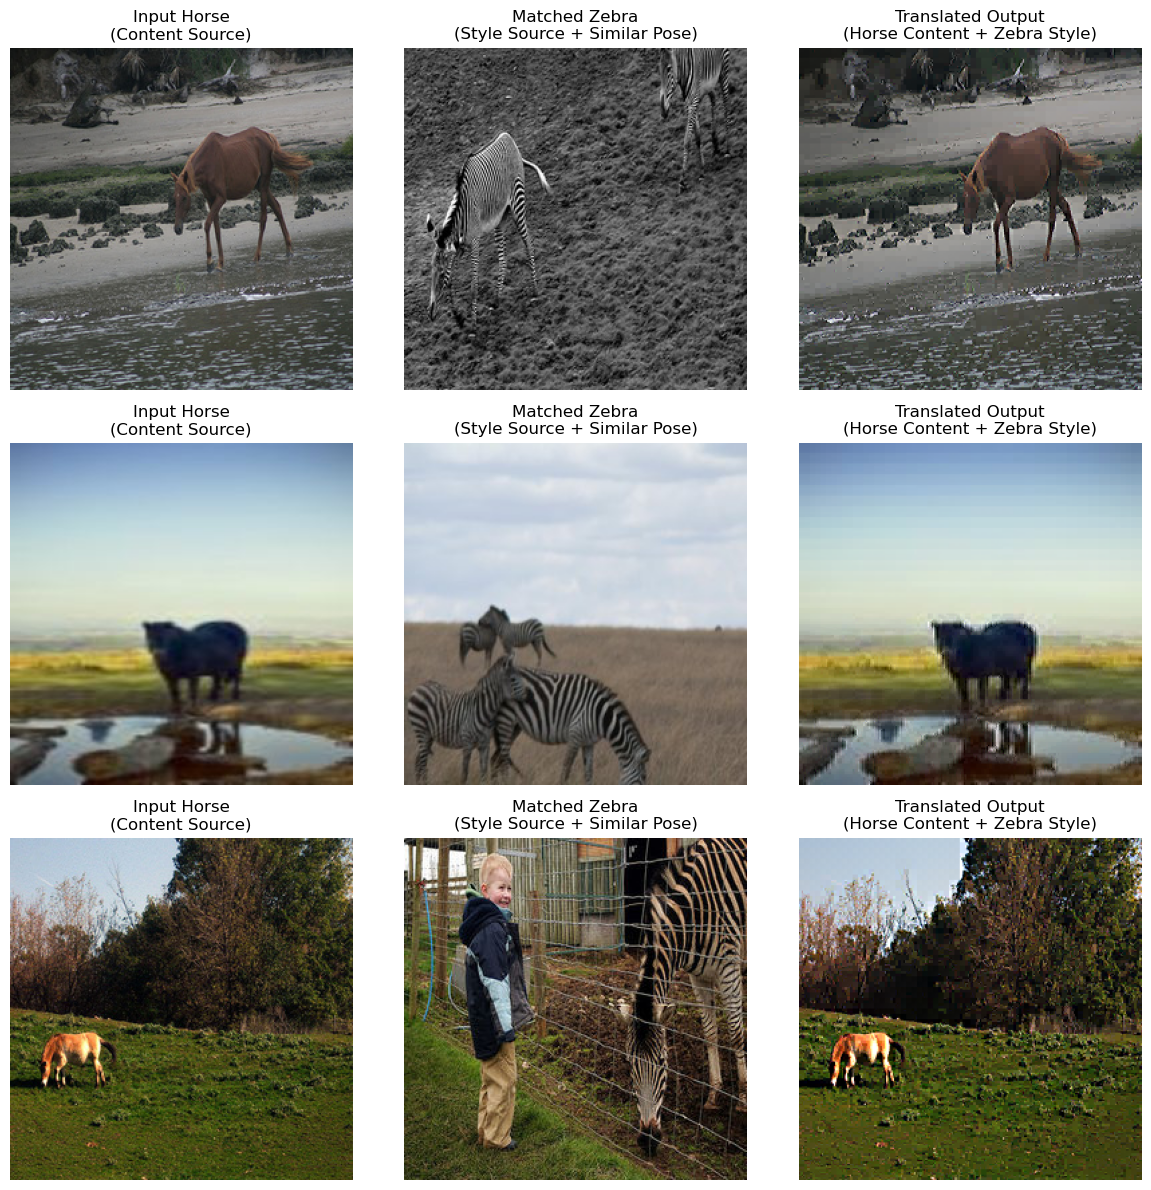

In [26]:
from sklearn.neighbors import NearestNeighbors

# --- 1. Setup the Databases ---
# We need to separate the latent vectors Z by domain
indices_A = [i for i, x in enumerate(df_meta['domain']) if x == 'A']
indices_B = [i for i, x in enumerate(df_meta['domain']) if x == 'B']

Z_A = Z[indices_A]
Z_B = Z[indices_B]

# Helper to map back from subset index to global index (for plotting original images)
def get_global_idx(subset_idx, domain):
    if domain == 'A': return indices_A[subset_idx]
    else: return indices_B[subset_idx]

# --- 2. Build the Matcher ---
# We match based ONLY on the Inactive (Content) dimensions.
# We want to find a Zebra (B) that has the same pose as the query Horse (A).

# Filter Z_B to keep only content dimensions
Z_B_content = Z_B[:, inactive_mask]

# Fit Nearest Neighbor model on Domain B's content
nbrs_B = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(Z_B_content)

# --- 4. Visualize Results ---
# Pick random horses to translate
test_indices = np.random.choice(len(Z_A), 3, replace=False)

plt.figure(figsize=(12, 12))

for i, idx_A in enumerate(test_indices):
    # Run Translation
    img_fake_zebra, idx_B = translate_A_to_B_statistical(idx_A)
    
    # Get Originals for Comparison
    global_idx_A = get_global_idx(idx_A, 'A')
    global_idx_B = get_global_idx(idx_B, 'B')
    
    img_real_horse = Image.open(df_meta.iloc[global_idx_A]['path']).convert('RGB').resize(IMG_SIZE)
    img_real_zebra_match = Image.open(df_meta.iloc[global_idx_B]['path']).convert('RGB').resize(IMG_SIZE)
    
    # Plotting
    # Column 1: Input Horse
    plt.subplot(3, 3, 3*i + 1)
    plt.imshow(img_real_horse)
    plt.title(f"Input Horse\n(Content Source)")
    plt.axis('off')
    
    # Column 2: Matched Zebra
    plt.subplot(3, 3, 3*i + 2)
    plt.imshow(img_real_zebra_match)
    plt.title(f"Matched Zebra\n(Style Source + Similar Pose)")
    plt.axis('off')
    
    # Column 3: Result
    plt.subplot(3, 3, 3*i + 3)
    plt.imshow(img_fake_zebra)
    plt.title(f"Translated Output\n(Horse Content + Zebra Style)")
    plt.axis('off')

plt.tight_layout()
plt.show()